In [63]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import scipy.stats as stats
from pathlib import Path
import sys
import matplotlib.pyplot as plt


In [64]:
BASE_PATH = Path.cwd().parent
TESTING_FILES_BASE_PATH = BASE_PATH/"testing"/"files"
sys.path.append(str(BASE_PATH))

In [65]:
from model.main import EMOTIONS

def plot_beliefs(Prob_User, Prob_Character, Prob_Character_label):
    x = np.arange(len(EMOTIONS))
    width = 0.35

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, Prob_User, width, label="System's belief about User's state")
    bars2 = ax.bar(x + width/2, Prob_Character, width, label=Prob_Character_label)

    ax.set_xlabel('Mental States')
    ax.set_ylabel('Probability')
    ax.set_title('Belief Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(EMOTIONS)
    ax.legend()

    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()

In [66]:
def entropy(dist):
    dist = np.array(dist)
    dist = dist[dist > 0]  # Avoid log(0)
    return -np.sum(dist * np.log2(dist))


In [ ]:
def analyse_files(folder_path, num_files):
    Prob_Users = []
    Prob_Characters = []
    L1s = []
    jsds = []
    pearson_corrs = []
    spearman_corrs = []
    entropy_users = []
    entropy_characters = []
    entropy_deltas = []

    for i in range(num_files):
        df = pd.read_csv(folder_path/("message_"+str(i+1)+"_belief_dist.csv"))
        Prob_Users.append(df["Prob_User"])
        Prob_Characters.append(df["Prob_Character"])

        L1 = sum(abs(prob_user - prob_character) for prob_user, prob_character in zip(df["Prob_User"], df["Prob_Character"])) # L1 norm distance (manhattan)
        L1s.append(L1)

        jsd = jensenshannon(df["Prob_User"], df["Prob_Character"], base=2) # Jensen-Shannon Divergence
        jsds.append(jsd)
        
        pearson_corr, _ = stats.pearsonr(df["Prob_User"], df["Prob_Character"]) # Pearson correlation (linear)
        pearson_corrs.append(pearson_corr)
        
        spearman_corr, _ = stats.spearmanr(df["Prob_User"], df["Prob_Character"]) # Spearman correlation (rank)
        spearman_corrs.append(spearman_corr)

        entropy_user = entropy(df["Prob_User"])
        entropy_users.append(entropy_user)

        entropy_character = entropy(df["Prob_Character"])
        entropy_characters.append(entropy_character)

        entropy_delta = abs(entropy_user-entropy_character)
        entropy_deltas.append(entropy_delta)

    return Prob_Users, Prob_Characters, L1s, jsds, pearson_corrs, spearman_corrs, entropy_users, entropy_characters, entropy_deltas

In [ ]:
def analyse_files_correlation(folder_path, num_files):
    Prob_Users = []
    Prob_Characters = []
    L1s = []
    jsds = []
    pearson_corrs = []
    spearman_corrs = []
    entropy_users = []
    entropy_characters = []
    entropy_deltas = []

    for i in range(num_files):
        df = pd.read_csv(folder_path/("message_"+str(i+1)+"_belief_dist.csv"))
        Prob_Users.append(df["Prob_User"])
        Prob_Characters.append(df["Prob_Character"])

        L1 = sum(abs(prob_user - prob_character) for prob_user, prob_character in zip(df["Prob_User"], df["Prob_Character"])) # L1 norm distance (manhattan)
        L1s.append(L1)

        jsd = jensenshannon(df["Prob_User"], df["Prob_Character"], base=2) # Jensen-Shannon Divergence
        jsds.append(jsd)
        
        pearson_corr, _ = stats.pearsonr(df["Prob_User"], df["Prob_Character"]) # Pearson correlation (linear)
        pearson_corrs.append(pearson_corr)
        
        spearman_corr, _ = stats.spearmanr(df["Prob_User"], df["Prob_Character"]) # Spearman correlation (rank)
        spearman_corrs.append(spearman_corr)

        entropy_user = entropy(df["Prob_User"])
        entropy_users.append(entropy_user)

        entropy_character = entropy(df["Prob_Character"])
        entropy_characters.append(entropy_character)

        entropy_delta = abs(entropy_user-entropy_character)
        entropy_deltas.append(entropy_delta)

    return Prob_Users, Prob_Characters, L1s, jsds, pearson_corrs, spearman_corrs, entropy_users, entropy_characters, entropy_deltas

In [68]:
# Subcases are either explicit or implicit emotions in prompt (explicit is control) 
class TestCaseSubcase():
    # Read files and generate stats
    def __init__(self, folder_path_stats, file_path_messages):
        with open(file_path_messages, encoding="utf-8") as f_explicit:
            self.messages = f_explicit.read().split("\n")

        self.num_files = len(self.messages)
        self.Prob_Users = []
        self.Prob_Characters = []
        self.L1s = []
        self.jsds = []
        self.pearson_corrs = []
        self.spearman_corrs = []
        self.entropy_users = []
        self.entropy_characters = []
        self.entropy_deltas = []

        for i in range(self.num_files):
            df = pd.read_csv(folder_path_stats/("message_"+str(i+1)+"_belief_dist.csv"))
            self.Prob_Users.append(df["Prob_User"])
            self.Prob_Characters.append(df["Prob_Character"])

            L1 = sum(abs(prob_user - prob_character) for prob_user, prob_character in zip(df["Prob_User"], df["Prob_Character"])) # L1 norm distance (manhattan)
            self.L1s.append(L1)

            jsd = jensenshannon(df["Prob_User"], df["Prob_Character"], base=2) # Jensen-Shannon Divergence
            self.jsds.append(jsd)
            
            pearson_corr, _ = stats.pearsonr(df["Prob_User"], df["Prob_Character"]) # Pearson correlation (linear)
            self.pearson_corrs.append(pearson_corr)
            
            spearman_corr, _ = stats.spearmanr(df["Prob_User"], df["Prob_Character"]) # Spearman correlation (rank)
            self.spearman_corrs.append(spearman_corr)

            entropy_user = entropy(df["Prob_User"])
            self.entropy_users.append(entropy_user)

            entropy_character = entropy(df["Prob_Character"])
            self.entropy_characters.append(entropy_character)

            entropy_delta = entropy_user-entropy_character
            self.entropy_deltas.append(entropy_delta)

    def display_stats(self, prob_character_label):
        for i in range(self.num_files):
            print("\n------------------------------------------------------------------" \
            "\n"+str(i+1)+"-User message:", self.messages[i])
            plot_beliefs(self.Prob_Users[i], self.Prob_Characters[i], prob_character_label)
            print("L1 distance:", self.L1s[i])
            print("Jensen-Shannon Divergence:", self.jsds[i])
            print("Pearson Correlation:", self.pearson_corrs[i])
            print("Spearman Correlation:", self.spearman_corrs[i])
            print("Entropy of User's belief distribution:", self.entropy_users[i])
            print("Entropy of Other character's belief distribution:", self.entropy_characters[i])
            print("Entropy delta:", self.entropy_deltas[i])

In [69]:
# Test Case
class TestCase():
    def __init__(self, folder_path_explicit, file_path_messages_explicit, folder_path_implicit, file_path_messages_implicit, prob_character_label):
        self.prob_character_label = prob_character_label
        self.subcase_explicit = TestCaseSubcase(folder_path_explicit, file_path_messages_explicit)
        self.subcase_implicit = TestCaseSubcase(folder_path_implicit, file_path_messages_implicit)

    def display_stats(self):
        self.subcase_explicit.display_stats(self.prob_character_label)
        self.subcase_implicit.display_stats(self.prob_character_label)
    

    


Get and display all results individually

CASE 1: Other character's dist = System's belief about other character's state



------------------------------------------------------------------
1-User message: Hi, I’m feeling really frustrated. A colleague presented work that I spent a lot of time on, and they didn’t acknowledge my role in it at all. I’m upset, but I also don’t want to come across as petty. What’s the best way to bring this up?


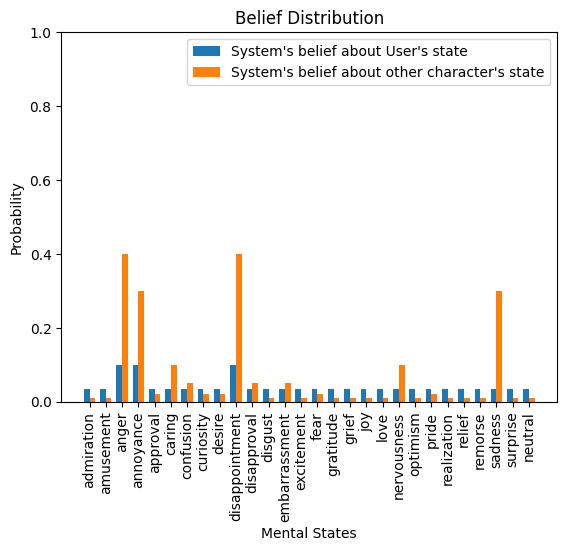

L1 distance: 1.6742857142857153
Jensen-Shannon Divergence: 0.44372742457286596
Pearson Correlation: 0.8682229503108695
Spearman Correlation: 0.5676733633868591
Entropy of User's belief distribution: 5.28885960887478
Entropy of Other character's belief distribution: 4.906922151166125
Entropy delta: 0.3819374577086556

------------------------------------------------------------------
2-User message: I’m honestly feeling pretty overwhelmed. My manager constantly checks in on every detail of what I’m doing, and it’s starting to make me doubt myself. I don’t want to be disrespectful, but I need more breathing room.


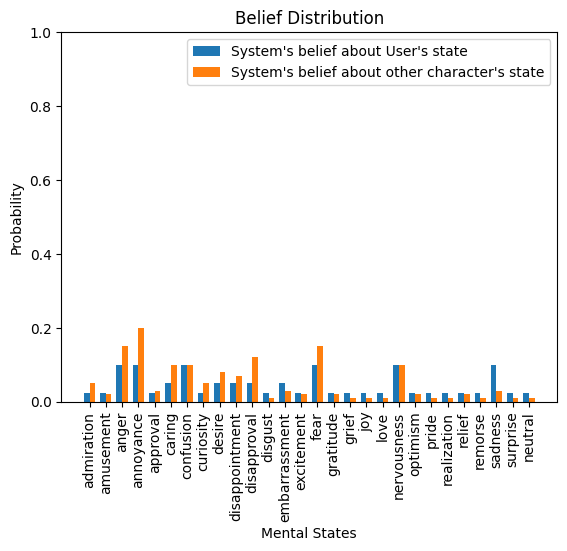

L1 distance: 0.6750000000000003
Jensen-Shannon Divergence: 0.2438029236642906
Pearson Correlation: 0.8001596766612833
Spearman Correlation: 0.8207482289657452
Entropy of User's belief distribution: 5.335458320981389
Entropy of Other character's belief distribution: 5.259010469862904
Entropy delta: 0.07644785111848496

------------------------------------------------------------------
3-User message: I’m starting to feel worn down. A teammate keeps making these passive-aggressive comments when we’re working together, and while they act like it’s nothing, it’s getting under my skin. How do I call this out without making things worse?


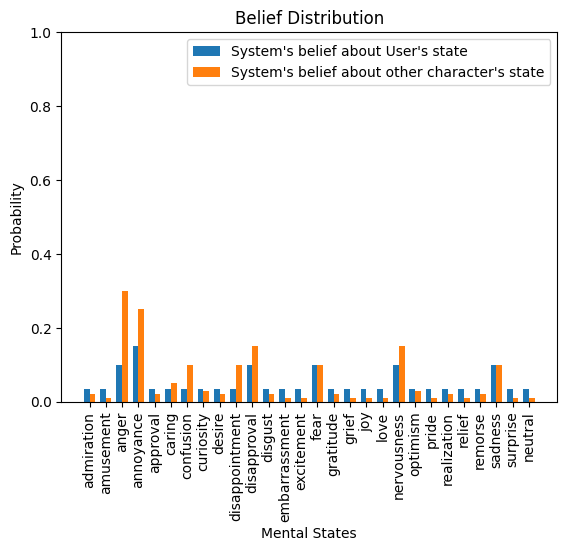

L1 distance: 0.9214285714285709
Jensen-Shannon Divergence: 0.3055218937911923
Pearson Correlation: 0.8549343184536865
Spearman Correlation: 0.7141883509470037
Entropy of User's belief distribution: 5.848716325328155
Entropy of Other character's belief distribution: 5.145106106088186
Entropy delta: 0.7036102192399687

------------------------------------------------------------------
4-User message: I’m annoyed and a bit resentful. I’m working on a joint project, and I’ve done almost everything while my colleague barely shows up. I don’t want to create tension, but I can’t keep picking up the slack.


In [ ]:


# Case 1: Other character's distribution is system's belief of other character
folder_path_explicit = TESTING_FILES_BASE_PATH/"case_1"/"explicit_emotions"
file_path_messages_explicit = BASE_PATH/r"testing/files/user_inputs/inputs_explicit_emotions.txt"
folder_path_implicit = TESTING_FILES_BASE_PATH/"case_1"/"implicit_emotions"
file_path_messages_implicit = BASE_PATH/r"testing/files/user_inputs/inputs_implicit_emotions.txt"
prob_character_label = "System's belief about other character's state"
test_case_1 = TestCase(folder_path_explicit, file_path_messages_explicit, folder_path_implicit, file_path_messages_implicit, prob_character_label)

print("CASE 1: Other character's dist = "+prob_character_label+"\n\n")
test_case_1.display_stats()








CASE 2: Other character's dist = System's belief about user's belief about other character's state


------------------------------------------------------------------
1-User message: Hi, I’m feeling really frustrated. A colleague presented work that I spent a lot of time on, and they didn’t acknowledge my role in it at all. I’m upset, but I also don’t want to come across as petty. What’s the best way to bring this up?


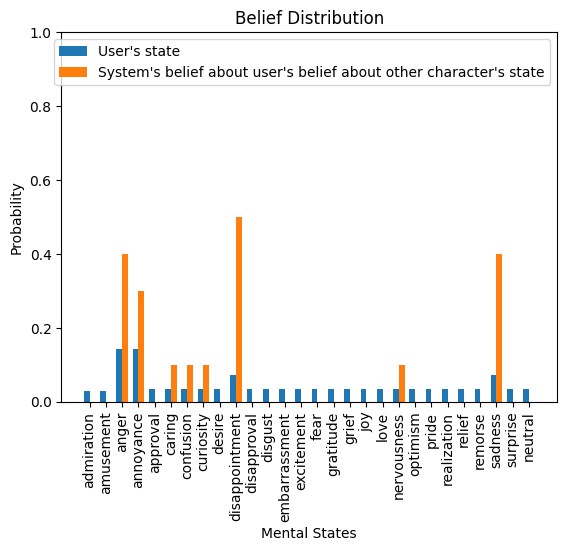

L1 distance: 2.128571428571427
Jensen-Shannon Divergence: 0.611487110066604
Pearson Correlation: 0.775539928637027
Spearman Correlation: 0.6876736923940467
Entropy of User's belief distribution: 5.416318577752514
Entropy of Other character's belief distribution: 3.4074033921146967
Entropy delta: 2.008915185637817

------------------------------------------------------------------
2-User message: I’m honestly feeling pretty overwhelmed. My manager constantly checks in on every detail of what I’m doing, and it’s starting to make me doubt myself. I don’t want to be disrespectful, but I need more breathing room.


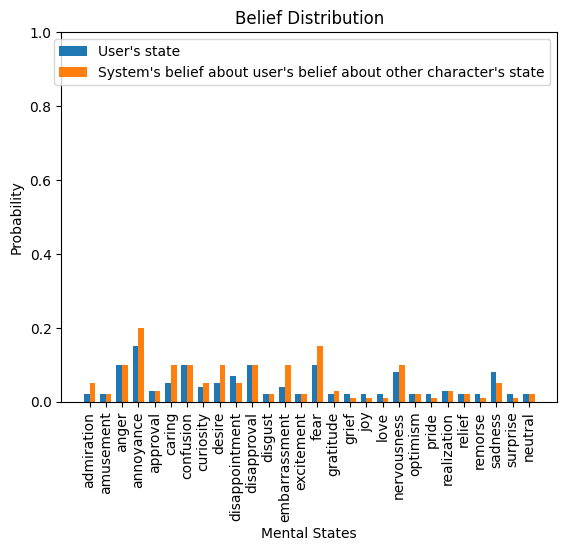

L1 distance: 0.44000000000000006
Jensen-Shannon Divergence: 0.16816787307914643
Pearson Correlation: 0.8897061871672564
Spearman Correlation: 0.8876213355002469
Entropy of User's belief distribution: 5.278402815334884
Entropy of Other character's belief distribution: 5.5958602896753025
Entropy delta: -0.3174574743404186

------------------------------------------------------------------
3-User message: I’m starting to feel worn down. A teammate keeps making these passive-aggressive comments when we’re working together, and while they act like it’s nothing, it’s getting under my skin. How do I call this out without making things worse?


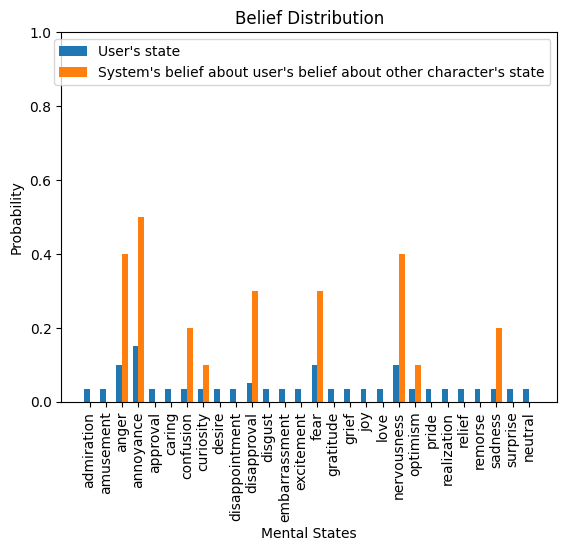

L1 distance: 2.535714285714284
Jensen-Shannon Divergence: 0.5737487100736229
Pearson Correlation: 0.8814479063807876
Spearman Correlation: 0.8038756866156067
Entropy of User's belief distribution: 5.572118358311394
Entropy of Other character's belief distribution: 4.192878689342031
Entropy delta: 1.3792396689693627

------------------------------------------------------------------
4-User message: I’m annoyed and a bit resentful. I’m working on a joint project, and I’ve done almost everything while my colleague barely shows up. I don’t want to create tension, but I can’t keep picking up the slack.


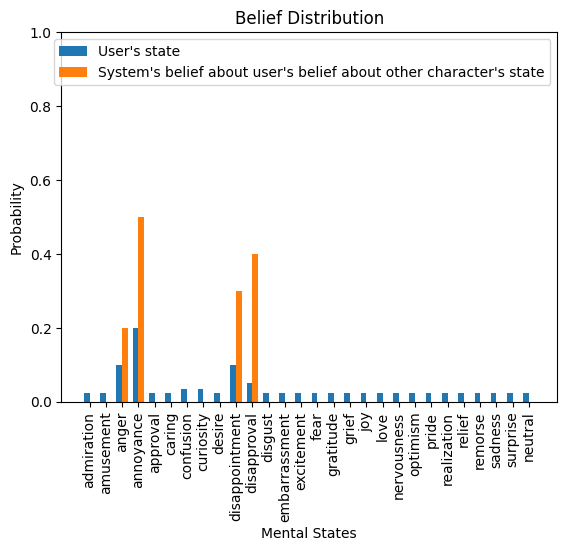

L1 distance: 1.5699999999999985
Jensen-Shannon Divergence: 0.6320218352590664
Pearson Correlation: 0.8739157280827416
Spearman Correlation: 0.8440416266084628
Entropy of User's belief distribution: 4.610483183627562
Entropy of Other character's belief distribution: 2.0142465351822794
Entropy delta: 2.596236648445283

------------------------------------------------------------------
5-User message: I’m feeling disrespected. A coworker frequently talks over me or dismisses what I say in meetings, and it’s chipping away at my confidence. How do I assert myself without causing conflict?


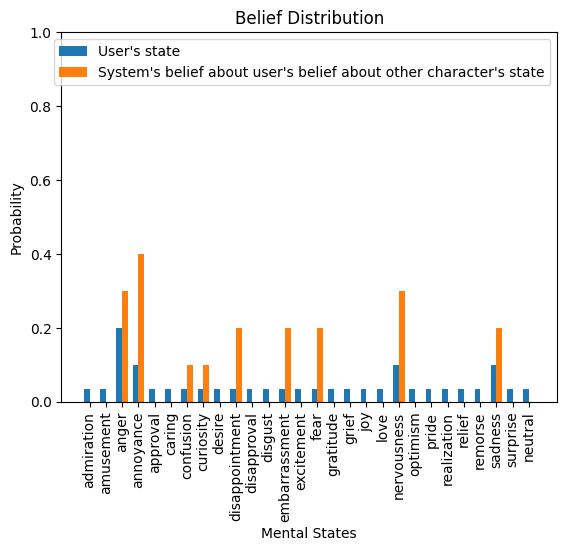

L1 distance: 1.9999999999999991
Jensen-Shannon Divergence: 0.5812561050194485
Pearson Correlation: 0.7122287627380105
Spearman Correlation: 0.7092518847897441
Entropy of User's belief distribution: 5.581553980635911
Entropy of Other character's belief distribution: 4.092878689342031
Entropy delta: 1.4886752912938794

------------------------------------------------------------------
6-User message: I feel really uncomfortable. A coworker makes jokes that cross the line, but they always laugh it off like it’s nothing. I’m not sure how to say something without it becoming a big deal, but I can’t keep pretending it’s okay.


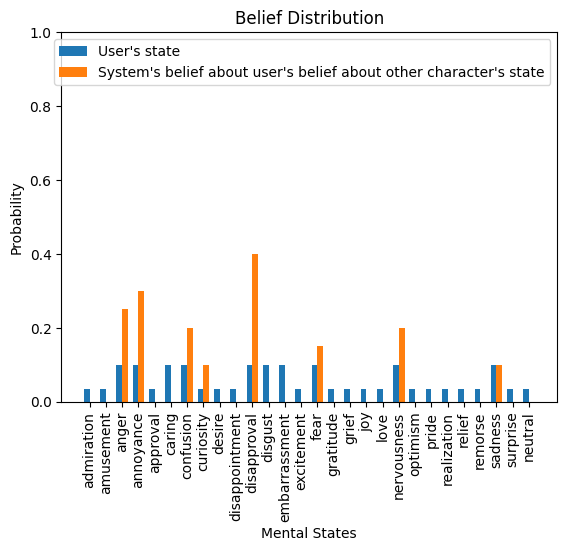

L1 distance: 1.8714285714285706
Jensen-Shannon Divergence: 0.6096013577337357
Pearson Correlation: 0.6798305648749293
Spearman Correlation: 0.706084191605356
Entropy of User's belief distribution: 6.412370544781534
Entropy of Other character's belief distribution: 3.553562612262155
Entropy delta: 2.8588079325193787

------------------------------------------------------------------
7-User message: I’m getting really frustrated. I’m supposed to be collaborating with someone who barely responds to messages or updates me on progress, and it’s slowing everything down. How do I bring this up directly but professionally?


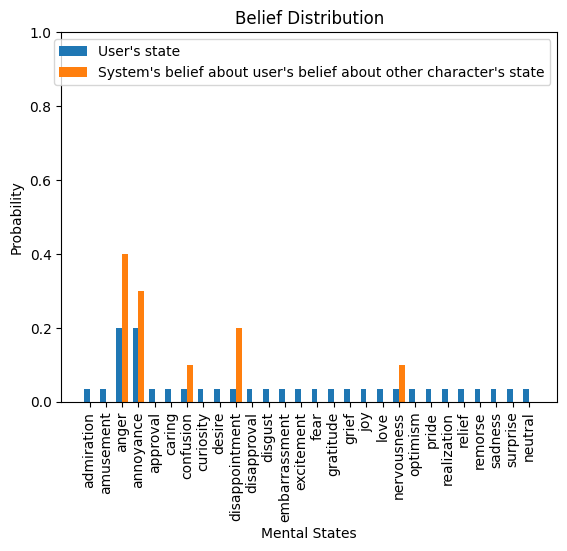

L1 distance: 1.4142857142857133
Jensen-Shannon Divergence: 0.6541563349364544
Pearson Correlation: 0.8828507200445751
Spearman Correlation: 0.6685057506204758
Entropy of User's belief distribution: 5.392743665579859
Entropy of Other character's belief distribution: 2.1786321541597515
Entropy delta: 3.2141115114201075

------------------------------------------------------------------
8-User message: I’m feeling hurt and confused. I recently got promoted, and someone I was close with at work has been acting cold and distant since then. I don’t want to lose that connection, but I don’t know how to fix this.


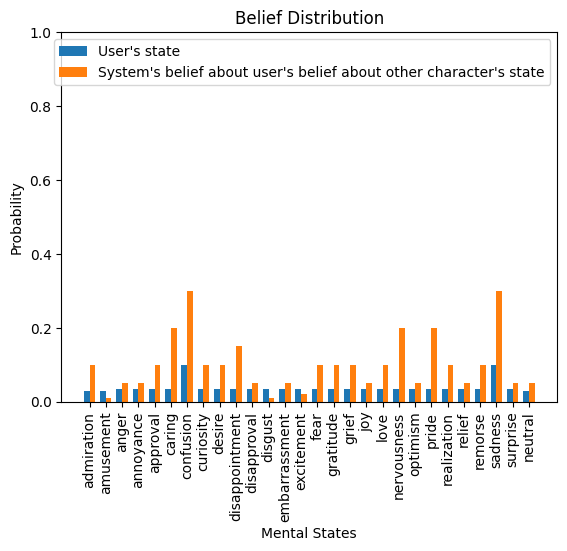

L1 distance: 1.8528571428571432
Jensen-Shannon Divergence: 0.23520625977076576
Pearson Correlation: 0.7477843044874357
Spearman Correlation: 0.4615633623207245
Entropy of User's belief distribution: 5.0529371349772125
Entropy of Other character's belief distribution: 8.358431037734736
Entropy delta: -3.305493902757523

------------------------------------------------------------------
9-User message: I’m feeling drained. There’s someone on my team who constantly positions themselves for recognition—even when the work was shared. I’m tired of being sidelined but don’t want to come off as bitter.


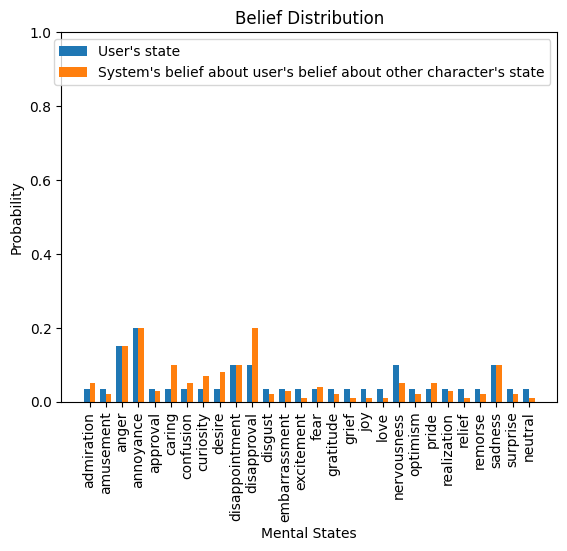

L1 distance: 0.6057142857142854
Jensen-Shannon Divergence: 0.23801101855449258
Pearson Correlation: 0.8236072620636536
Spearman Correlation: 0.6662057415727717
Entropy of User's belief distribution: 5.980909134816892
Entropy of Other character's belief distribution: 5.477292502210996
Entropy delta: 0.5036166326058966

------------------------------------------------------------------
10-User message: I’m frustrated and honestly a little anxious. My project partner has a chaotic, last-minute approach that clashes completely with my structured style. It’s causing a lot of stress. How can I address this without creating more tension?


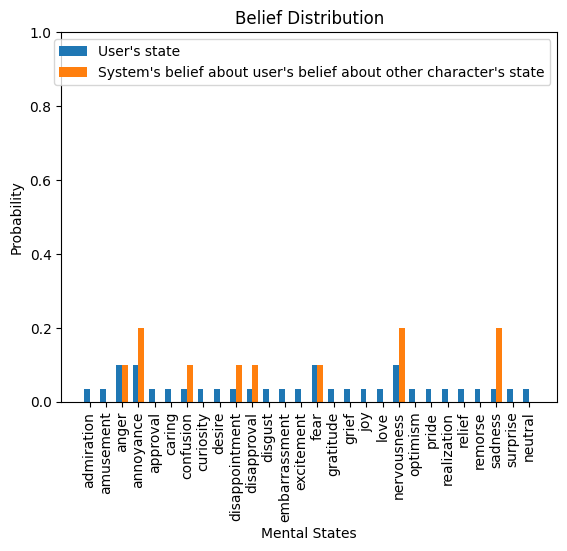

L1 distance: 1.2714285714285714
Jensen-Shannon Divergence: 0.6297626033508302
Pearson Correlation: 0.6716946545270314
Spearman Correlation: 0.6688731601341364
Entropy of User's belief distribution: 5.449361171147173
Entropy of Other character's belief distribution: 3.0541209043760986
Entropy delta: 2.395240266771075

------------------------------------------------------------------
1-User message: Hey, I was wondering how to handle something. A colleague recently took the lead in presenting work we both did,but didn’t mention my involvement at all. What’s the right way to bring this up without sounding accusatory?


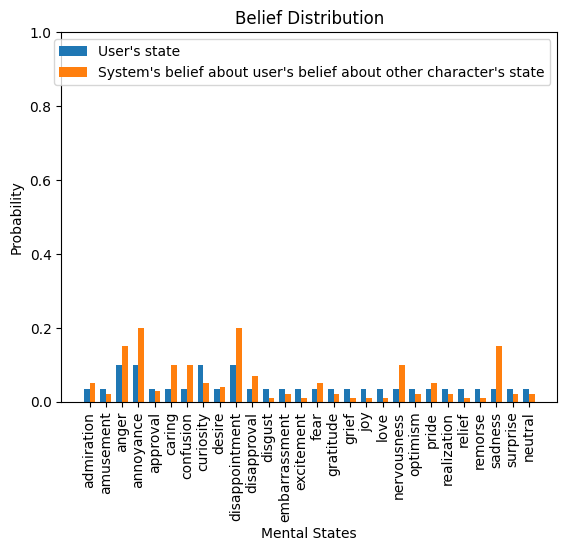

L1 distance: 0.9842857142857141
Jensen-Shannon Divergence: 0.3185904089391778
Pearson Correlation: 0.6811416627012961
Spearman Correlation: 0.5273526099241365
Entropy of User's belief distribution: 5.449361171147173
Entropy of Other character's belief distribution: 5.472110910503976
Entropy delta: -0.02274973935680258

------------------------------------------------------------------
2-User message: I could use some guidance. My manager is very involved in every little detail of my work. I know they mean well,but it’s making it hard for me to focus or feel like I own anything.


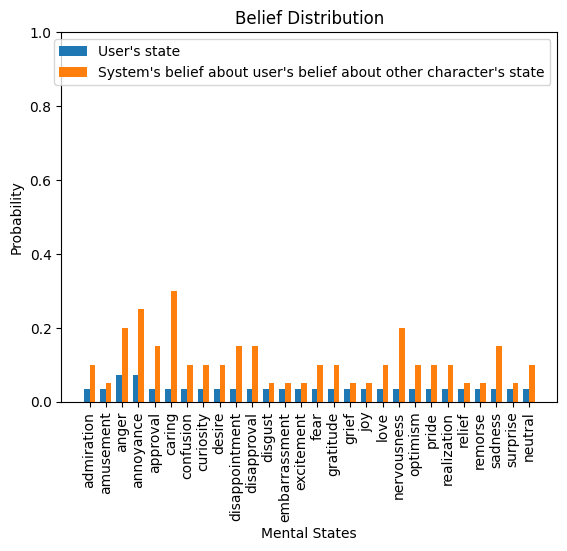

L1 distance: 2.0285714285714285
Jensen-Shannon Divergence: 0.1992915179437719
Pearson Correlation: 0.5016561414422667
Spearman Correlation: 0.4243321297663356
Entropy of User's belief distribution: 5.007880273633143
Entropy of Other character's belief distribution: 9.191028819779943
Entropy delta: -4.1831485461468

------------------------------------------------------------------
3-User message: There’s a person on my team who keeps making subtle digs when we work together, usually disguised as jokes or comments. It’s never outright hostile, but it definitely impacts how we collaborate.


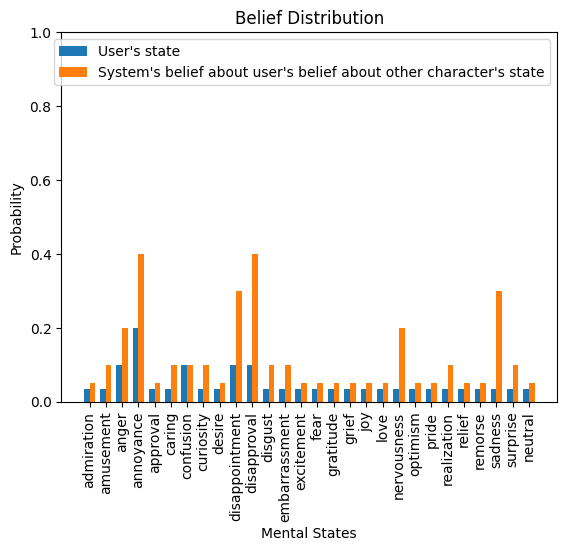

L1 distance: 1.8785714285714281
Jensen-Shannon Divergence: 0.21480280907151433
Pearson Correlation: 0.7530698056294741
Spearman Correlation: 0.6302010732150938
Entropy of User's belief distribution: 5.742055542908303
Entropy of Other character's belief distribution: 8.711385212695603
Entropy delta: -2.9693296697873004

------------------------------------------------------------------
4-User message: I’m working with someone on a project, and it feels like I’m carrying the bulk of the responsibility. They haven’t contributed much, but we’re supposed to share the outcome. What’s a good way to approach this?


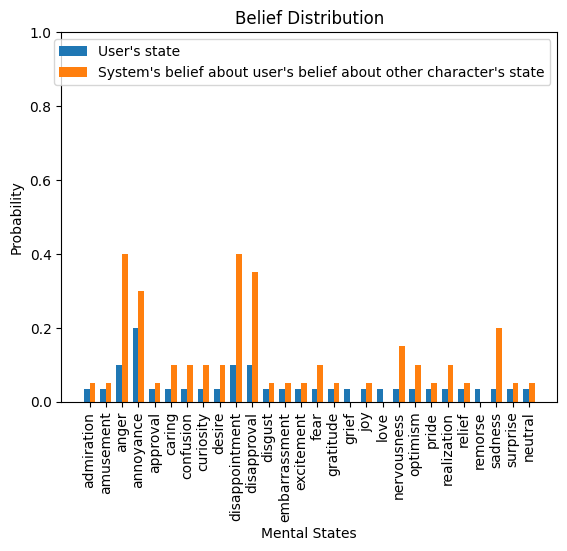

L1 distance: 1.9571428571428566
Jensen-Shannon Divergence: 0.27909651776348576
Pearson Correlation: 0.7558875939891511
Spearman Correlation: 0.6332455283724545
Entropy of User's belief distribution: 5.58155398063591
Entropy of Other character's belief distribution: 7.902169746106141
Entropy delta: -2.3206157654702313

------------------------------------------------------------------
5-User message: In team meetings, a coworker often interrupts or dismisses what I’m saying. It’s not every time, but it happens enough that I’ve started hesitating to speak up. What can I do to shift this dynamic?


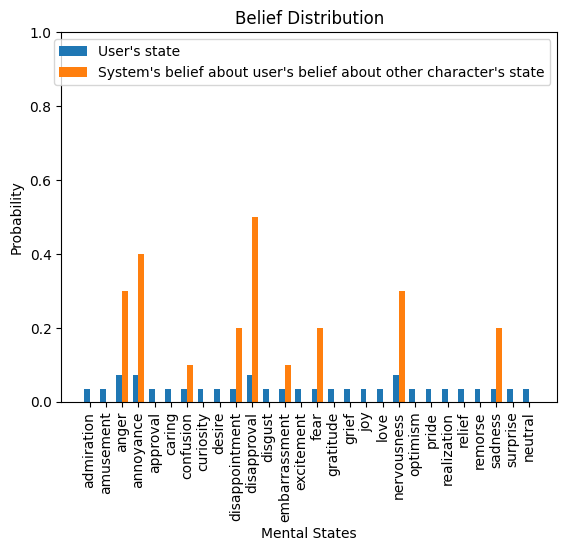

L1 distance: 2.5142857142857133
Jensen-Shannon Divergence: 0.6308363584816654
Pearson Correlation: 0.8600662598876548
Spearman Correlation: 0.7320417798624029
Entropy of User's belief distribution: 5.2084056252086866
Entropy of Other character's belief distribution: 4.128493070364558
Entropy delta: 1.0799125548441282

------------------------------------------------------------------
6-User message: One of my coworkers has a habit of making “jokes” that are a little too personal or off-color. They usually brush it off as humor, but I’d like to address it in a way that keeps things professional.


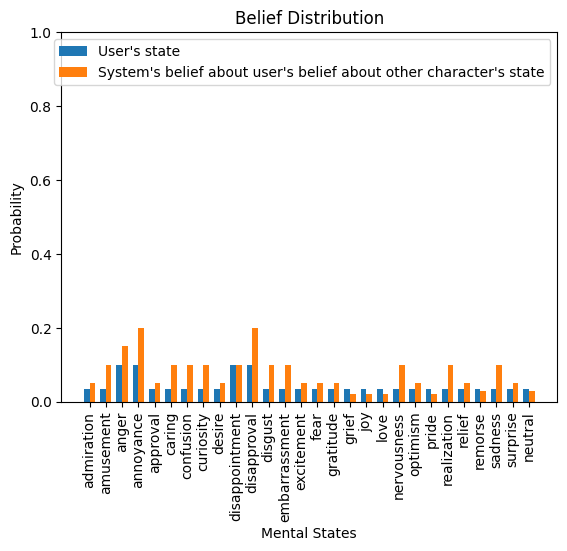

L1 distance: 1.0314285714285718
Jensen-Shannon Divergence: 0.196259123712273
Pearson Correlation: 0.7301823489785177
Spearman Correlation: 0.5734188736403837
Entropy of User's belief distribution: 5.449361171147173
Entropy of Other character's belief distribution: 7.361153931191745
Entropy delta: -1.9117927600445714

------------------------------------------------------------------
7-User message: I’m working closely with someone who isn’t great at responding to messages or keeping me in the loop. It’s creating a lot of delays, and I’m not sure how to bring it up without sounding confrontational.


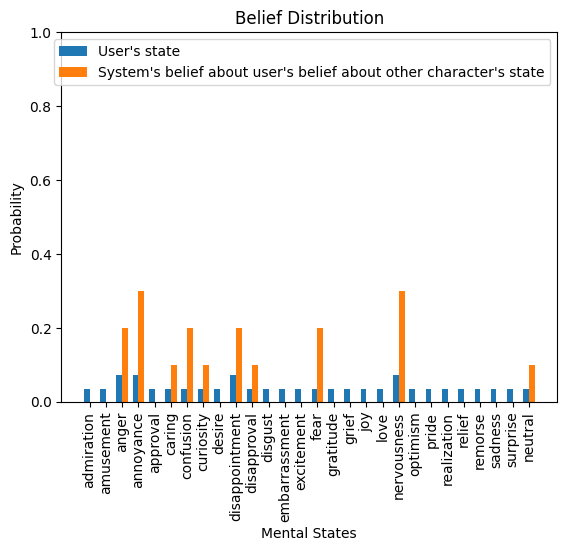

L1 distance: 1.9428571428571415
Jensen-Shannon Divergence: 0.6089842752514262
Pearson Correlation: 0.7803902927439637
Spearman Correlation: 0.6806896049877201
Entropy of User's belief distribution: 5.2084056252086866
Entropy of Other character's belief distribution: 4.228493070364559
Entropy delta: 0.9799125548441276

------------------------------------------------------------------
8-User message: Since I got promoted, a colleague I used to be close with has been acting distant and keeping conversations short. I’d like to clear the air, but I’m not sure how to start that conversation.


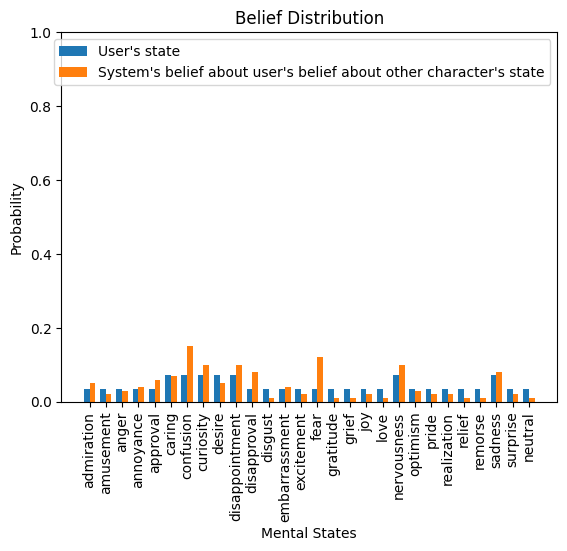

L1 distance: 0.6571428571428568
Jensen-Shannon Divergence: 0.26985652302371765
Pearson Correlation: 0.6985400095608028
Spearman Correlation: 0.6573388018736843
Entropy of User's belief distribution: 5.509193652572002
Entropy of Other character's belief distribution: 5.1188638127960635
Entropy delta: 0.39032983977593894

------------------------------------------------------------------
9-User message: There’s someone on my team who always seems to get ahead by making sure their work is seen—sometimes even when it’s shared work. I want to stand out too, but not by playing the same game.


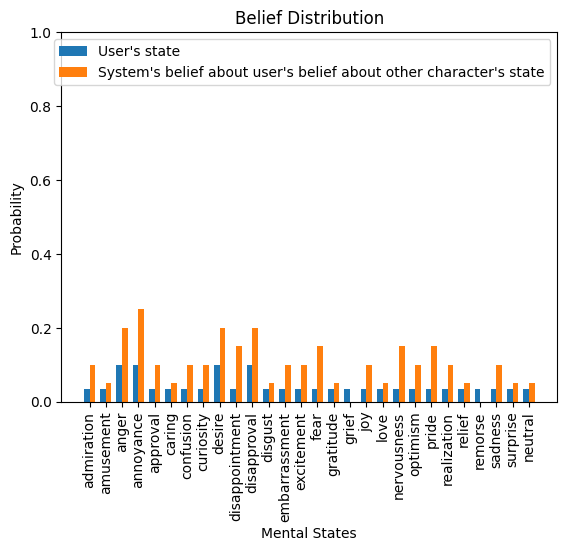

L1 distance: 1.7357142857142855
Jensen-Shannon Divergence: 0.2231950455002194
Pearson Correlation: 0.7473677532236447
Spearman Correlation: 0.6296508373623833
Entropy of User's belief distribution: 5.449361171147173
Entropy of Other character's belief distribution: 8.586035546274449
Entropy delta: -3.136674375127275

------------------------------------------------------------------
10-User message: I’ve been paired with someone whose approach to work is completely different from mine—very last-minute and reactive. It’s tough to stay on the same page. How can I navigate this without creating friction?


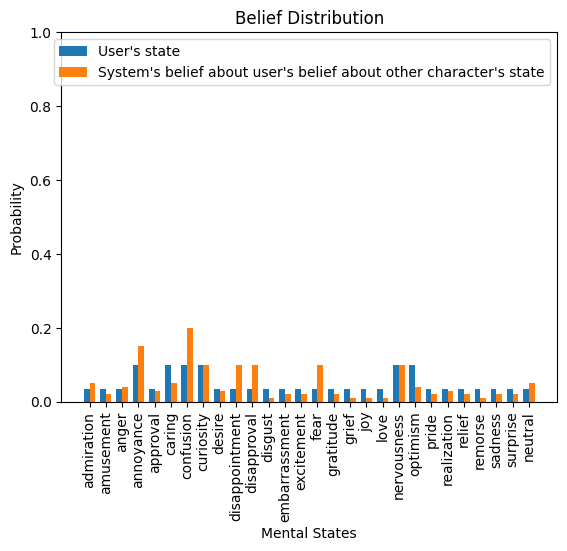

L1 distance: 0.7571428571428569
Jensen-Shannon Divergence: 0.2806092615154871
Pearson Correlation: 0.6389561597065782
Spearman Correlation: 0.5872564796594263
Entropy of User's belief distribution: 5.7703642956919605
Entropy of Other character's belief distribution: 5.246202446828681
Entropy delta: 0.5241618488632795


In [ ]:
# Case 2: Other character's distribution is system's belief of other character
folder_path_explicit = TESTING_FILES_BASE_PATH/"case_2"/"explicit_emotions"
file_path_messages_explicit = BASE_PATH/r"testing/files/user_inputs/inputs_explicit_emotions.txt"
folder_path_implicit = TESTING_FILES_BASE_PATH/"case_2"/"implicit_emotions"
file_path_messages_implicit = BASE_PATH/r"testing/files/user_inputs/inputs_implicit_emotions.txt"
prob_character_label = "System's belief about user's belief about other character's state"
test_case_2 = TestCase(folder_path_explicit, file_path_messages_explicit, folder_path_implicit, file_path_messages_implicit, prob_character_label)

print("CASE 2: Other character's dist = "+prob_character_label+"\n")
test_case_2.display_stats()

High level overview

C:\Users\dchal\AppData\Local\Temp\ipykernel_14132\1013964876.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


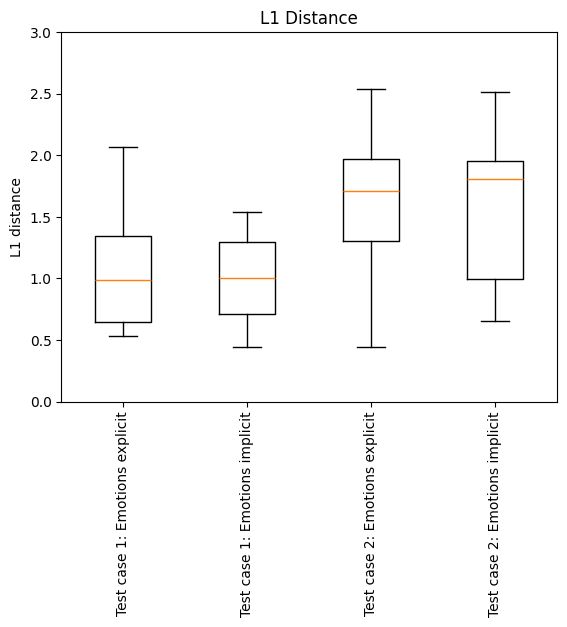

C:\Users\dchal\AppData\Local\Temp\ipykernel_14132\1013964876.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


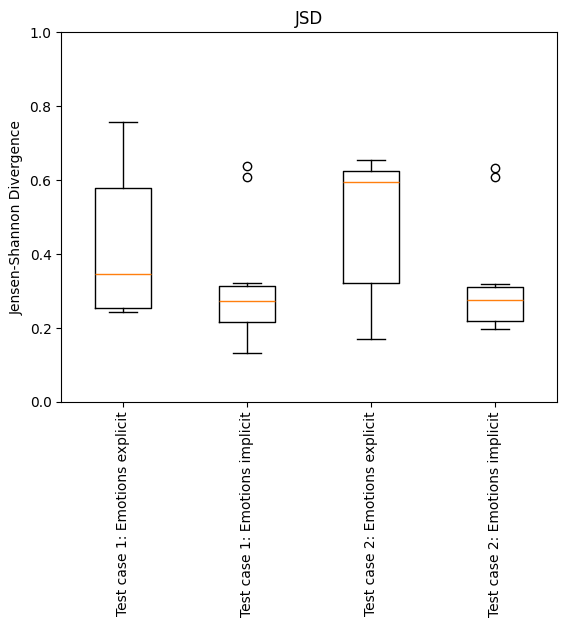

C:\Users\dchal\AppData\Local\Temp\ipykernel_14132\1013964876.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


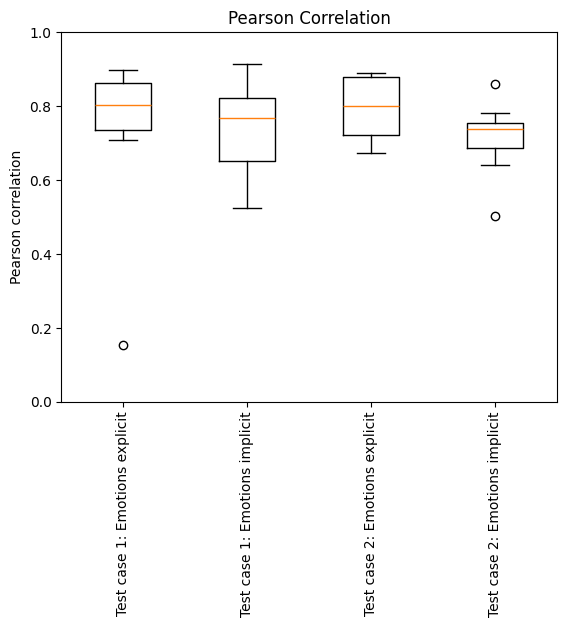

C:\Users\dchal\AppData\Local\Temp\ipykernel_14132\1013964876.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


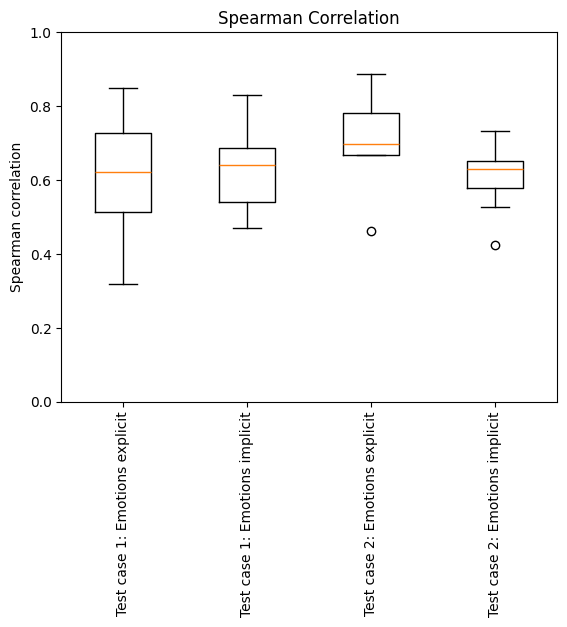

C:\Users\dchal\AppData\Local\Temp\ipykernel_14132\1013964876.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


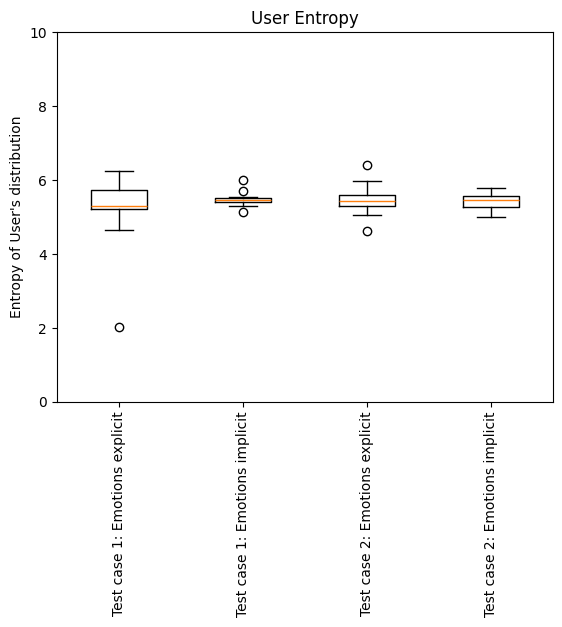

C:\Users\dchal\AppData\Local\Temp\ipykernel_14132\1013964876.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


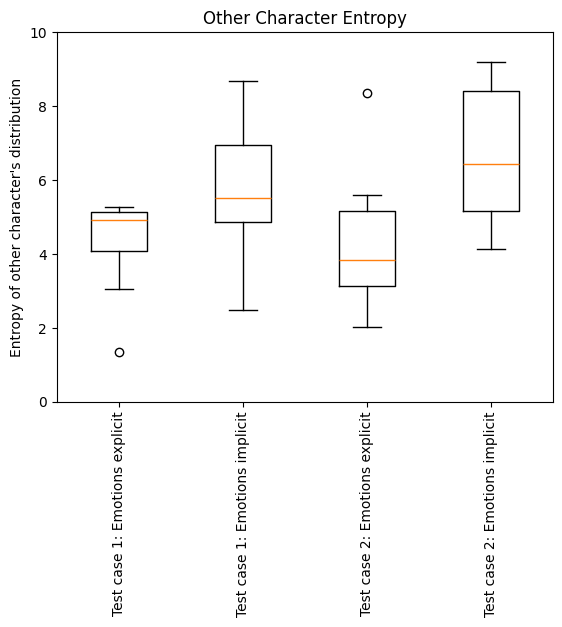

C:\Users\dchal\AppData\Local\Temp\ipykernel_14132\1013964876.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


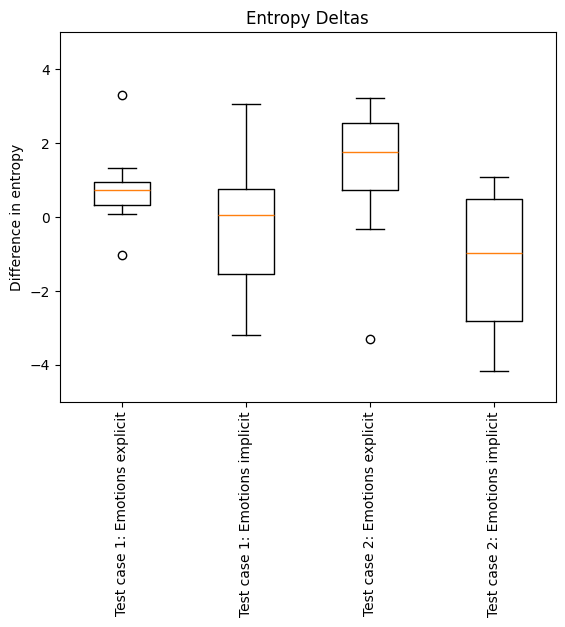

In [ ]:
def show_aggregated_results(test_case_1, test_case_2):
    labels = [
        'Test case 1: Emotions explicit', 'Test case 1: Emotions implicit',
        'Test case 2: Emotions explicit', 'Test case 2: Emotions implicit'
    ]

    # L1 Distance
    plt.boxplot([
        test_case_1.subcase_explicit.L1s,
        test_case_1.subcase_implicit.L1s,
        test_case_2.subcase_explicit.L1s,
        test_case_2.subcase_implicit.L1s
    ], labels=labels)
    plt.ylabel("L1 distance")
    plt.ylim(0, 3)
    plt.title("L1 Distance")
    plt.xticks(rotation=90)
    plt.show()

    # JSD
    plt.boxplot([
        test_case_1.subcase_explicit.jsds,
        test_case_1.subcase_implicit.jsds,
        test_case_2.subcase_explicit.jsds,
        test_case_2.subcase_implicit.jsds
    ], labels=labels)
    plt.ylabel("Jensen-Shannon Divergence")
    plt.ylim(0, 1)
    plt.title("JSD")
    plt.xticks(rotation=90)
    plt.show()

    # Pearson Correlation
    plt.boxplot([
        test_case_1.subcase_explicit.pearson_corrs,
        test_case_1.subcase_implicit.pearson_corrs,
        test_case_2.subcase_explicit.pearson_corrs,
        test_case_2.subcase_implicit.pearson_corrs
    ], labels=labels)
    plt.ylabel("Pearson correlation")
    plt.ylim(0, 1)
    plt.title("Pearson Correlation")
    plt.xticks(rotation=90)
    plt.show()

    # Spearman Correlation
    plt.boxplot([
        test_case_1.subcase_explicit.spearman_corrs,
        test_case_1.subcase_implicit.spearman_corrs,
        test_case_2.subcase_explicit.spearman_corrs,
        test_case_2.subcase_implicit.spearman_corrs
    ], labels=labels)
    plt.ylabel("Spearman correlation")
    plt.ylim(0, 1)
    plt.title("Spearman Correlation")
    plt.xticks(rotation=90)
    plt.show()

    # Entropy (Users)
    plt.boxplot([
        test_case_1.subcase_explicit.entropy_users,
        test_case_1.subcase_implicit.entropy_users,
        test_case_2.subcase_explicit.entropy_users,
        test_case_2.subcase_implicit.entropy_users
    ], labels=labels)
    plt.ylabel("Entropy of User's distribution")
    plt.ylim(0, 10)
    plt.title("User Entropy")
    plt.xticks(rotation=90)
    plt.show()

    # Entropy (Other Characters)
    plt.boxplot([
        test_case_1.subcase_explicit.entropy_characters,
        test_case_1.subcase_implicit.entropy_characters,
        test_case_2.subcase_explicit.entropy_characters,
        test_case_2.subcase_implicit.entropy_characters
    ], labels=labels)
    plt.ylabel("Entropy of other character's distribution")
    plt.ylim(0, 10)
    plt.title("Other Character Entropy")
    plt.xticks(rotation=90)
    plt.show()

    # Entropy Deltas
    plt.boxplot([
        test_case_1.subcase_explicit.entropy_deltas,
        test_case_1.subcase_implicit.entropy_deltas,
        test_case_2.subcase_explicit.entropy_deltas,
        test_case_2.subcase_implicit.entropy_deltas
    ], labels=labels)
    plt.ylabel("Difference in entropy")
    plt.ylim(-5, 5)
    plt.title("Entropy Deltas")
    plt.xticks(rotation=90)
    plt.show()

show_aggregated_results(test_case_1, test_case_2)
